In [1]:
from data_loader import load_data
from plot_utils import show_transform_plot
from functools import partial
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
train = load_data()

In [3]:
col_dtypes = train.dtypes
num_feats = col_dtypes[col_dtypes != 'object'].axes[0].tolist()
cat_feats = col_dtypes[col_dtypes == 'object'].axes[0].tolist()

## Correlation analysis

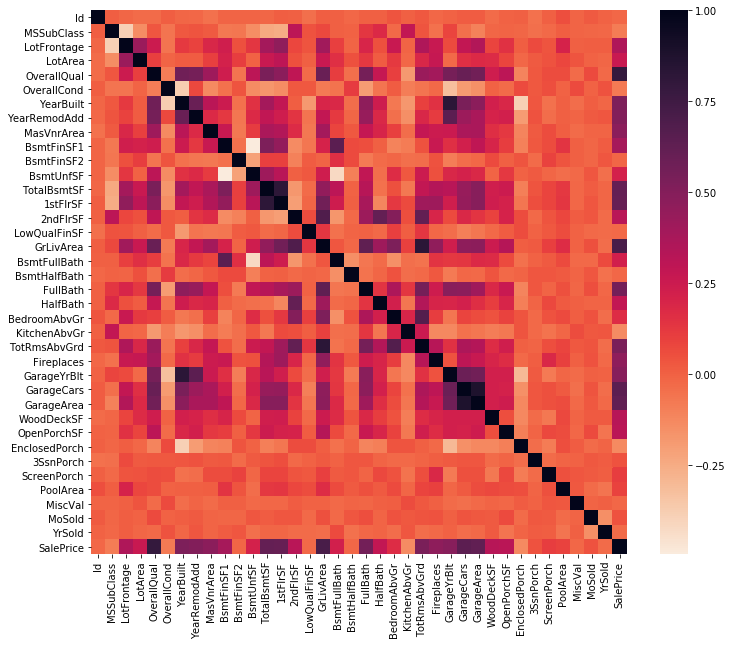

In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(method='pearson'), cmap=sns.cm.rocket_r)

Observations (based only on heatmap of correlations):  
1. Features most correlated with SalePrice means: Conditions and qualities, Square Footage of certain rooms and information about Garage  
2. Year built of garage are strong correlated with housr year built -> house in most cases was originallly built with garage.  
    - we can try to remove GarageYrBlt feature
3. Garage built year with cars and area -> some trend on garage size to be bigger (sic!)(???)
4. Garage feats with overall qual -> the better quality, the bigger, newer garages
5. OverallQual correlations -> bigger, newer houses
6. Basement SF correlation with 1st floor SF -> 1st SF similar to basement SF  
7. Bigger basement finished SF gives lower unfinished

# Sale Price analysis

In [5]:
# create variable for convenience
price = train['SalePrice']
# higher order function for convenience
show_log_transform = partial(show_transform_plot, trans_fun=np.log, fit_dist=stats.norm, metrics=[stats.skew, stats.kurtosis])

### Price description

In [6]:
price.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Pirice distribution

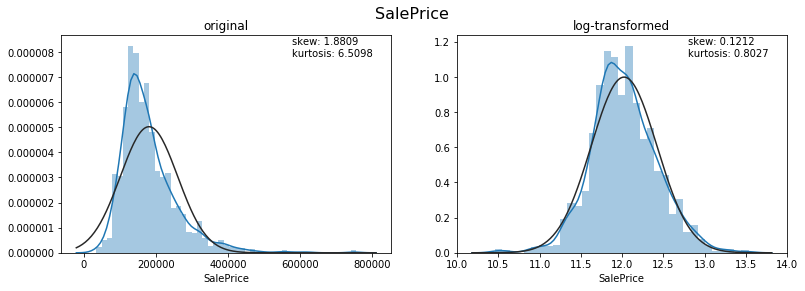

In [7]:
show_log_transform(price)

# Other countinuous variables analysis

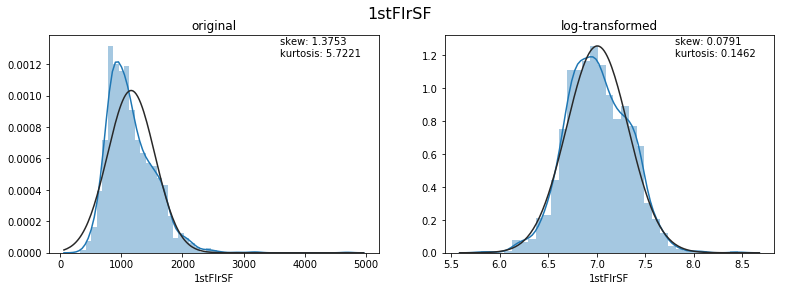

In [8]:
show_log_transform(train['1stFlrSF'])

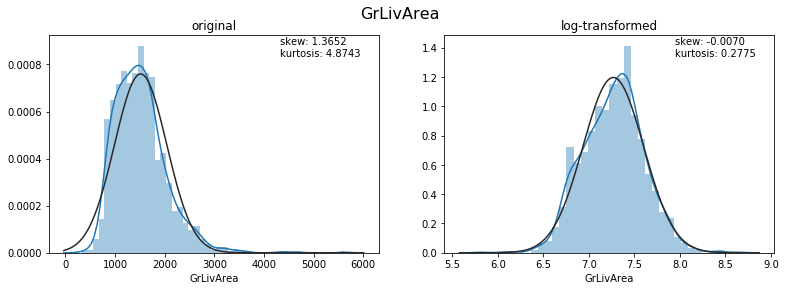

In [9]:
show_log_transform(train['GrLivArea'])

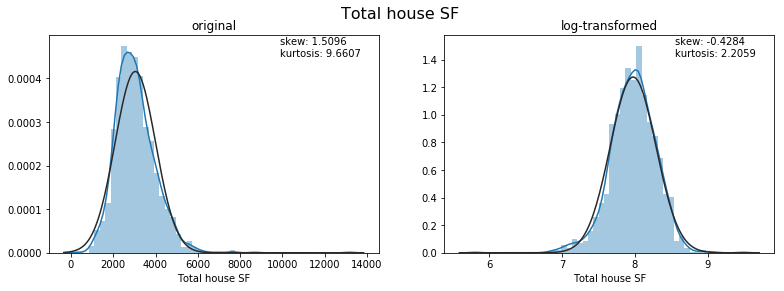

In [10]:
show_log_transform(pd.Series(train['GrLivArea']+train['TotalBsmtSF']+train['GarageArea'], name='Total house SF'))

1. 1stFlr and GrLivArea are both right skewed: apply log transformation gives good results at shape of distribution. BoxCox transformation is almost same like log-transform, so we could safely apply both
2. Total house SF means all area which belongs to house. However even, when transformation is applied, data has still posisitive kurtosis (undesirable high) so using such structural variable must be considered via model selection

### 2ndFlrSF 

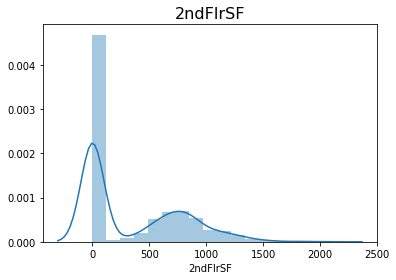

In [11]:
plt.title('2ndFlrSF', fontsize=16)
sns.distplot(train['2ndFlrSF'])

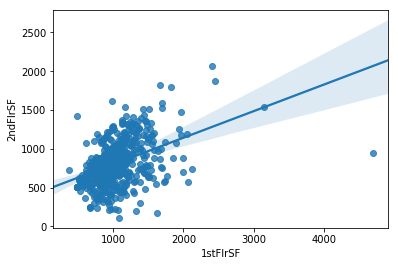

In [12]:
nonzero_2ndFlrSF = train['2ndFlrSF']>0
sns.regplot(train[nonzero_2ndFlrSF]['1stFlrSF'], train[nonzero_2ndFlrSF]['2ndFlrSF'])

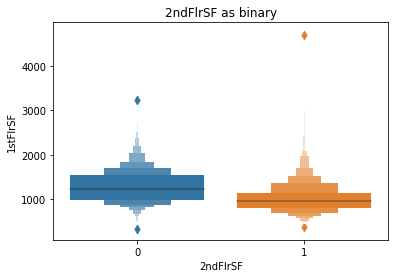

In [13]:
ndFlrSF_indicator = train['2ndFlrSF'].apply(lambda x:  1 if x>0 else 0)
plt.title('2ndFlrSF as binary')
sns.boxenplot(ndFlrSF_indicator, train['1stFlrSF'])

1. 2ndFlrSF is mostly 0 and normally distributed when greater than 0
    - applying indicator (whether 2ndFlr exists in the house) might be reasonable, since variable are positively correlated and correlation is preseved after such transformation (as shown in boxenplot above)

### Garage

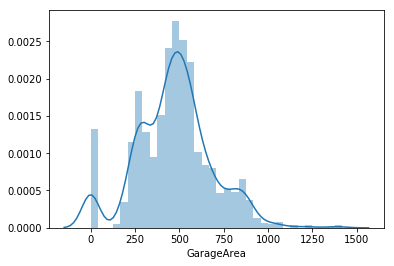

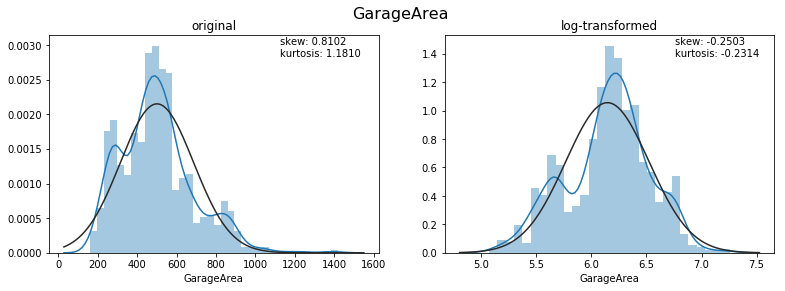

In [14]:
sns.distplot(train['GarageArea'])
show_log_transform(train[train['GarageArea']>0]['GarageArea'])

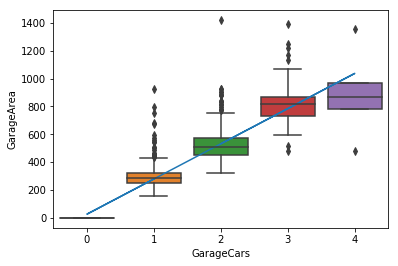

In [15]:
slope, intercept, _, _, _ = stats.linregress(train['GarageCars'],train['GarageArea'])
line = lambda x: slope*x+intercept
sns.boxplot('GarageCars', 'GarageArea', data=train)
plt.plot(train['GarageCars'],line(train['GarageCars']))

1. GarageArea distributon is messy and in order to some peaks it isn't good aproximation of normal distribution. In addition to this we see that there are many examples without garage (area = 0). Any transformatioan (log, boxcox) dosen't give us shape improvement
2. GarageCars are strongly correlated with GarageArea (multicolinearity), except the case there 4 cars garage, where regline doesn't fit so well as in the less car garages

### Basement

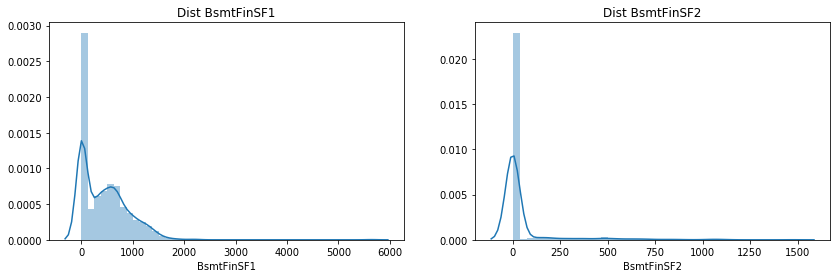

In [16]:
_, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].set_title('Dist BsmtFinSF1')
ax[1].set_title('Dist BsmtFinSF2')
sns.distplot(train['BsmtFinSF1'], ax = ax[0])
sns.distplot(train['BsmtFinSF2'], ax = ax[1])

In [17]:
train['BsmtFinSF2'].where(train['BsmtFinSF1']==0).unique()

array([nan,  0.])

Text(0.5,1,'BsmtFinSF1 when BsmtFinSF2>0')

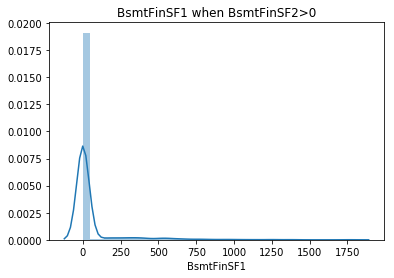

In [18]:
sns.distplot(train['BsmtFinSF1'].where(train['BsmtFinSF2']>0).fillna(0))
plt.title('BsmtFinSF1 when BsmtFinSF2>0')

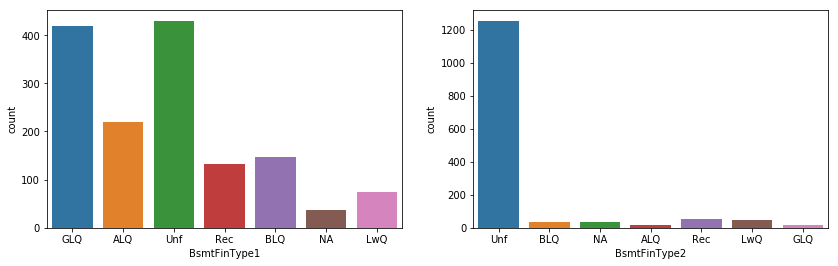

In [19]:
_,ax = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(train['BsmtFinType1'].fillna('NA'), ax=ax[0])
sns.countplot(train['BsmtFinType2'].fillna('NA'), ax=ax[1])

Text(0.5,1,'Dist finished/unfinished bsmt ratio')

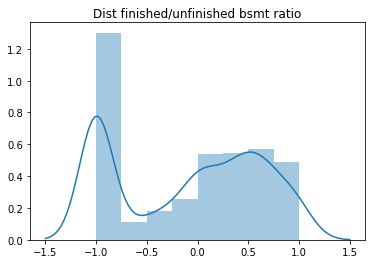

In [20]:
bmst_fin = train['BsmtFinSF1'] + train['BsmtFinSF2']
bmst_fin_unfin_ratio = ((bmst_fin - train['BsmtUnfSF'])/train['TotalBsmtSF']).fillna(0)
sns.distplot(bmst_fin_unfin_ratio)
plt.title('Dist finished/unfinished bsmt ratio')

1. BsmtFinSF2 is mostly equal to 0 and hasn't any significant correlation with SalePrice and any other feature (based on heatmap)
2. When there is no first type basement, hence there is no second type basement, but when bsmt type exists some SF of bsmt of type 1 are positive (when most is 0)
3. Most of cases has totally unfinished basement or partially finished/unfinished. Basement of type is almost always unfinshed/low-quality/Average Rec Room, so most of time we have basements not prepared for living

## Price correlation

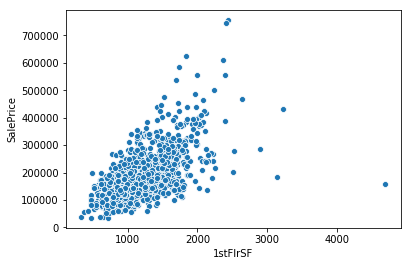

In [33]:
#example scatter presenting correlation
sns.scatterplot(train['1stFlrSF'], price)

#### Sum of areas correlation

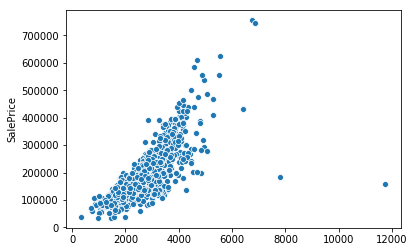

In [22]:
all_SF = train['GrLivArea']+train['TotalBsmtSF']
sns.scatterplot(all_SF, price)

1. All area of selling house is strongly correlated with SalePrice, so we can create such variable, however this structural multicolinearity has to be check for the sake of performance

# Other correlations (multicolinearity)

### LotFrontage vs. LotArea

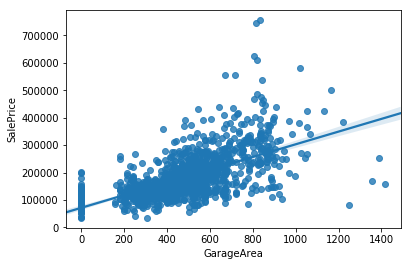

In [23]:
sns.regplot(train['GarageArea'], train['SalePrice'])

In [24]:
non_null_frontage_idx = train['LotFrontage'].notnull()
print('Raw values corr: ', stats.pearsonr(train[non_null_frontage_idx]['LotFrontage'], train[non_null_frontage_idx]['LotArea']))
print('Log trans values corr: ', stats.pearsonr(np.log(train[non_null_frontage_idx]['LotFrontage']), np.log(train[non_null_frontage_idx]['LotArea'])))

Raw values corr:  (0.42609501877180794, 3.697416826266103e-54)
Log trans values corr:  (0.745550090492558, 1.537012138757967e-213)


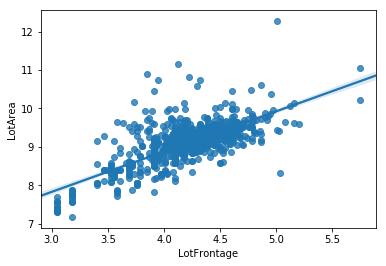

In [25]:
sns.regplot(np.log(train['LotFrontage']), np.log(train['LotArea']))

1. Taking logarithm of this two variables boosting correlation and deacreasing p-value(good)
2. The existence of correlation among this variables gives us abiblity to imput missing data in LotFrontage (e.g. by regression) or delete LotFrontage and rely only on LotArea feature (LotArea are more correlated to target than LotFrontage)  
3. We can replace this two variables by their sum
4. Some values seems to be outliers, that are: LotFrontage>300 and LotArea>200000 (in original data)

### 1stFlrSF vs TotalBsmtSF

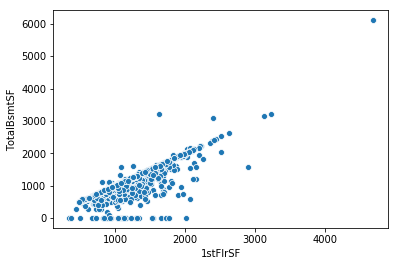

In [26]:
sns.scatterplot(train['1stFlrSF'], train['TotalBsmtSF'])

1. 1stFlrSF is strongly correlated with TotalBsmtSF, however there are houses without basement
    - we can replace feature TotalBsmtSF with binary feature indicating whether house containing basement or not (see below), this replacement reduce information about basementSF, but since it's correlated with 1stFlrSF (and other BsmtSF) we won't loose much information

# Numerical to categorical

## YearBuilt

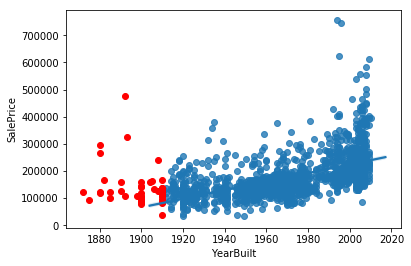

In [27]:
above_yr = train['YearBuilt']>1910
sns.regplot(train[above_yr]['YearBuilt'], train[above_yr]['SalePrice'])
plt.scatter(train[~above_yr]['YearBuilt'], train[~above_yr]['SalePrice'], color='red')

In [28]:
#Example of such discretization
YearBuilt_discretized = pd.cut(train['YearBuilt'], bins=[1910, 1960, 1990, 2005, 2010], labels=['retro', 'old', 'medium', 'new'], retbins=True)
# YearBuilt_discretized = pd.qcut(train['YearBuilt'], 7, retbins=True)
YearBuilt_discretized[1]

array([1910, 1960, 1990, 2005, 2010])

Text(0.5,1,'Discretized with SalePrice correlation')

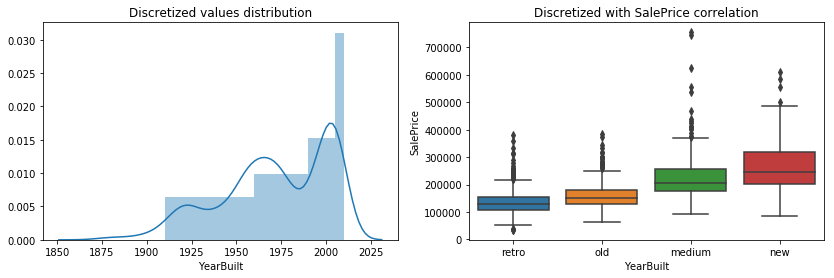

In [29]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(train['YearBuilt'], bins=YearBuilt_discretized[1], ax=ax[0])
ax[0].set_title('Discretized values distribution')
sns.boxplot(YearBuilt_discretized[0], price, ax=ax[1])
ax[1].set_title('Discretized with SalePrice correlation')

1. Since there are many examples of old houses that are not exactly as cheap as regline says, so we can discretize values of YearBuilt. Feasible division will be set during model selection, however it's seems resonable to divide due to regression line (especially very old houses wich are more expensive than supposed to be)  
    - ad-hoc solution (by observing regplot) to division seems to work well, but for each category (escpecially for the oldest houses) there is too much outliers
    - using qcut (cut continuous by quantilles) we got also good division (4-6 quantilles work the best), however it's also suffers from too much outliers in older houses

### TotalBsmtSF

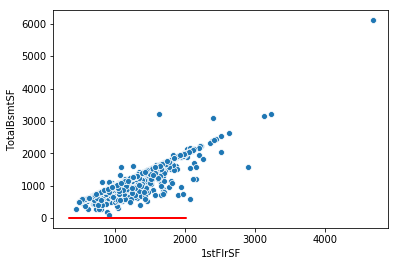

In [30]:
nonzero_TotalBsmtSF_idx = train['TotalBsmtSF']>0
sns.scatterplot(train[nonzero_TotalBsmtSF_idx]['1stFlrSF'], train[nonzero_TotalBsmtSF_idx]['TotalBsmtSF'])
plt.plot(train[~nonzero_TotalBsmtSF_idx]['1stFlrSF'], train[~nonzero_TotalBsmtSF_idx]['TotalBsmtSF'], color='red')

In [31]:
TotalBsmtSF_disc = train['TotalBsmtSF'].apply(lambda x: 0 if x==0 else 1)

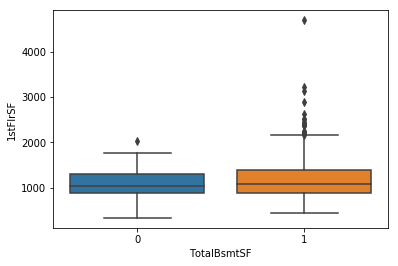

In [32]:
sns.boxplot(TotalBsmtSF_disc, train['1stFlrSF'])